# Mooring Data from the Rocakall Trough
EB1, WB1 & WB2

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import pandas as pd
import os
import gsw
from pathlib import Path
import re

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load data

In [3]:
data_path =  Path('../../Data/SAMS_moorings/') # Path('./data/')

Mooring              = rteb1_01_2014      
SerialNumber         = 11324      
WaterDepth           = 1800      
InstrDepth           = 730      
Start_Date           = 2014/07/18
Start_Time           = 12:30
End_Date             = 2015/06/20
End_Time             = 06:30
Latitude             = 57 05.960 N
Longitude            = 009 32.880 W
Columns              = YY:MM:DD:HH:T:C:P

In [7]:
def load_moor_data(data_path,moor,year):
    def __dms2dd(degrees, minutes, direction):
        dd = float(degrees) + float(minutes)/60;
        if direction == 'W' or direction == 'S':
            dd *= -1
        return dd;

    def __read_header(file):

        with open(file) as myfile:
            head = [next(myfile) for x in range(10)]
            attr_str={}
            coord_str={}
            for line in head:
                info = re.split('[ \n]+',line)
                if info[0]=='Latitude' or info[0]=='Longitude':
                    attr_str[info[0]] = __dms2dd(info[2],info[3],info[4])
                elif info[0]=='InstrDepth':
                    coord_str['depth'] = ('depth',[float(info[2])])
                else:
                    attr_str[info[0]] = info[2]
            attr_str['Latitude_units'] = 'degrees_north'
            attr_str['Longitude_units'] = 'degrees_east'
        return attr_str,coord_str
    
    def __load_csv_as_xr(file):
        attr_str = __read_header(file)
        cols = ['yyyy', 'mm', 'dd', 'hh', 'temp', 'cond', 'pres']
        df = pd.read_csv(file, sep='\s+' ,parse_dates={'dates': [0,1,2,3]}, squeeze=True, 
                         header = None, skiprows = 11, names = cols, engine='python')

        for idx,dt in enumerate(df['dates']):
            date_str =dt[:4]+dt[5:7]+dt[8:10]
            df['dates'][idx]=(pd.to_datetime(date_str,format='%Y%m%d')+datetime.timedelta(hours=np.float(dt[11:])))

        ds = xr.Dataset.from_dataframe(df)
        attr_str,coord_str = __read_header(file)
        ds.coords['time']=ds.dates
        ds = ds.swap_dims({'index':'time'}).drop('index').drop_vars('dates')
        ds.attrs = attr_str
        ds = ds.expand_dims('depth')
        ds = ds.assign_coords(coord_str)
        ds['sal'] = gsw.SP_from_C(ds.cond, ds.temp, ds.pres)
        ds = ds.drop_vars('cond')
        return ds

    def __get_filelist(data_path,moor,year):
        file_list = list(sorted(
            (data_path).glob(f"{moor}_??_{year}*/microcat/{moor}_*.microcat")
            ))
        return file_list

    files = __get_filelist(data_path,moor,year)
    ds = __load_csv_as_xr(files[0])
    for file in files[1:]:
        ds = xr.concat([ds,__load_csv_as_xr(file)],dim='depth')
    ds.depth.attrs['units']='m'
    
    ds.temp.attrs['standard_name'] = "sea_water_temperature" ;
    ds.temp.attrs['long_name'] = "In Situ Temperature of Sea Water" ;
    ds.temp.attrs['units'] = "degree_C" ;
    
    ds.sal.attrs['standard_name'] = "sea_water_salinity" ;
    ds.sal.attrs['long_name'] = "Practical Salinity on the PSS-78 scale" ;
    ds.sal.attrs['units'] = "unitless" ;
    
#     ds.pres.attrs['']
    
    return ds

In [17]:
%%time
moor = 'rtwb1'
ds = load_moor_data(data_path,moor,2014)
# depth_round=[]
# for idx,depth in enumerate(ds.depth):
#     if depth<60:
#         depth_round[idx]=50
#     elif 60<depth & depth<80:
#         depth_round[idx]=50
#     ...
# ds.coord['depth'] = depth_round
    
for year in np.arange(2015,2019):
    ds = xr.concat([ds,load_moor_data(data_path,'rtwb1',year)],dim='time')
ds

Wall time: 11min 21s


<xarray.Dataset>
Dimensions:  (depth: 22, time: 134156)
Coordinates:
  * depth    (depth) float64 50.0 80.0 100.0 ... 1.5e+03 1.557e+03 1.575e+03
  * time     (time) datetime64[ns] 2014-07-17T12:30:01.008000 ... 2020-10-14T...
Data variables:
    temp     (depth, time) float64 nan nan nan nan nan ... 4.383 nan 4.427 nan
    cond     (depth, time) float64 nan nan nan nan nan ... 33.6 nan 33.65 nan
    pres     (depth, time) float64 nan nan nan nan ... nan 1.589e+03 nan
    sal      (depth, time) float64 nan nan nan nan nan ... 35.01 nan 35.01 nan
Attributes:
    Mooring:          rtwb1_01_2014
    SerialNumber:     11335
    WaterDepth:       1600
    Start_Date:       2014/07/17
    Start_Time:       12:30
    End_Date:         2015/06/22
    End_Time:         10:30
    Latitude:         57.470666666666666
    Longitude:        -12.705
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

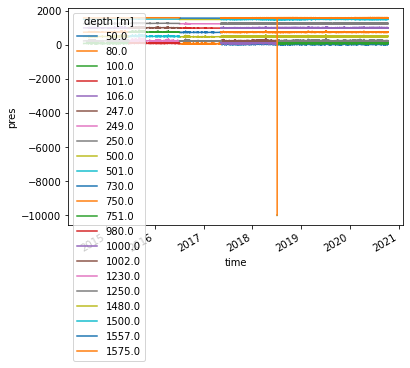

In [20]:
ds.pres.plot.line(x='time')